## Imbalanced Data

About 97% of the training data in this dataset is classified as 0, which means no claim, and only about 3% of the data is classified as 1, which means a claim.

So what we actually expect is:

The training set has more positive classes, that is, more 1s and more data with claims, so that we can better predict the positive class when inputting new data.

In [2]:
import numpy as np
import pandas as pd

from collections import Counter

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,12)
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
#plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

from sklearn.metrics import roc_curve, roc_auc_score

Did not make a claim: 573518
Made a claim: 21694
ratio: 26.44 : 1


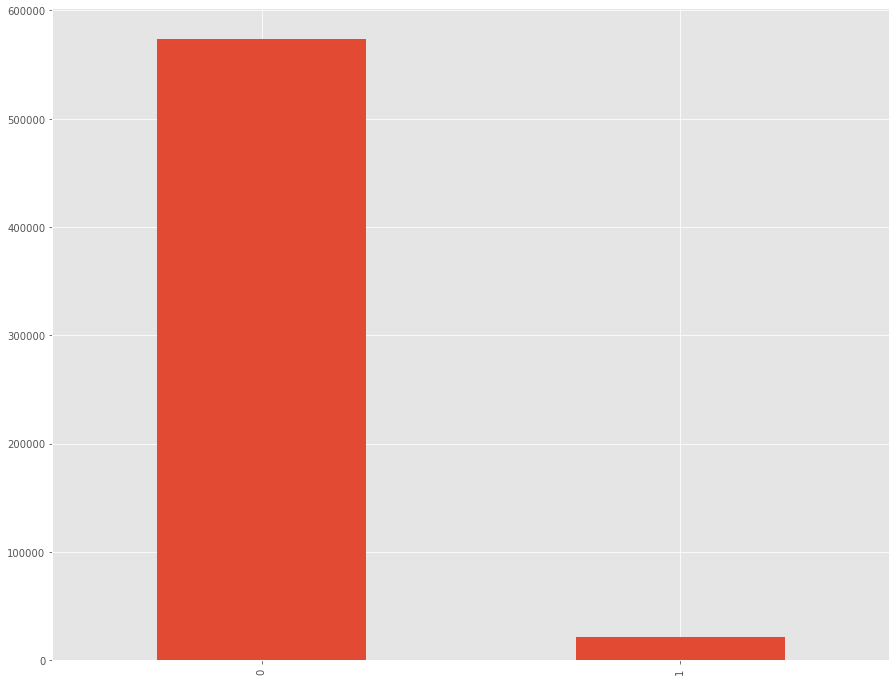

In [3]:
test = pd.read_csv('F:/BaiduNetdiskDownload/WhaleDataScienceProject-master/test.csv')
train = pd.read_csv('F:/BaiduNetdiskDownload/WhaleDataScienceProject-master/train.csv')

fullset = pd.concat([train,test],ignore_index=True)

target_count = train.target.value_counts()
print('Did not make a claim:', target_count[0])
print('Made a claim:', target_count[1])
print('ratio:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar');

It can be seen that the ratio of positive to negative classes is about 1 to 26, indicating that we have very few positive cases, and indeed, the case of insurance claims is very rare. This is a common problem in risk control projects, and we often encounter this situation. Such data is not very friendly to general machine learning algorithms. Why is this?

For example, if we do not process the data at all and directly use sklearn's Logistic regression to classify the data, let's see the results

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# remove id & target
features = train.columns[2:]

X = train[features]
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1996)

model = LogisticRegression(solver = 'liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.34%


The accuracy has reached 96.34% which is great, but let us put a random variable like ps_calc_02 into the model.

In [5]:
model.fit(X_train[['ps_calc_02']], y_train)
y_pred = model.predict(X_test[['ps_calc_02']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.34%


We can no longer using accuracy to determine this model whether is good or not because the data shows extrme bias.

In [6]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    114686
           1       0.00      0.00      0.00      4357

    accuracy                           0.96    119043
   macro avg       0.48      0.50      0.49    119043
weighted avg       0.93      0.96      0.95    119043



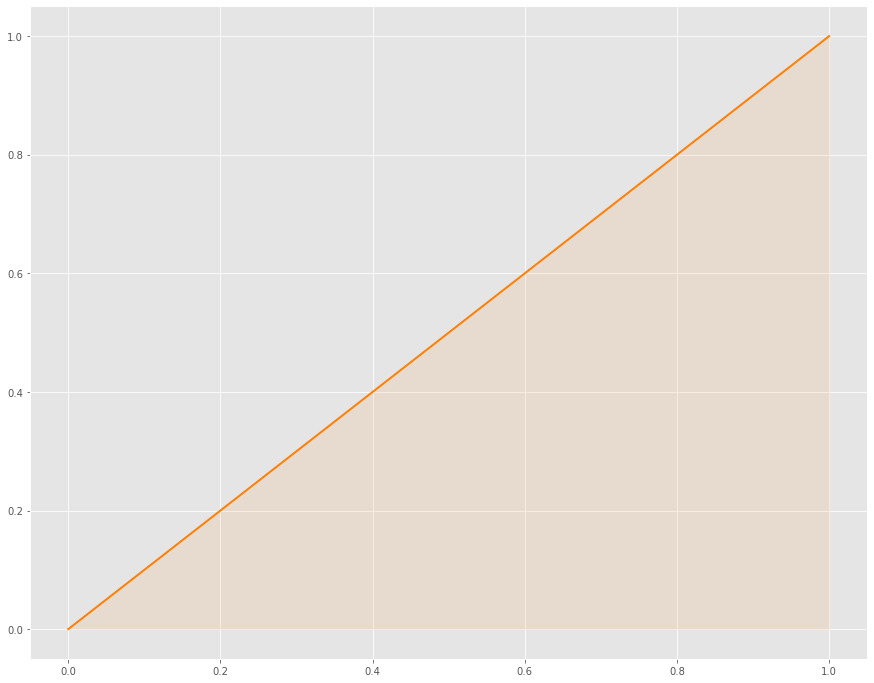

In [7]:
aucroc = roc_auc_score(y_test, y_pred)
fpr, tpr, t = roc_curve(y_test, y_pred)
fig, ax = plt.subplots(nrows=1,ncols=1, sharey=True)

ax.plot([0]+fpr.tolist(), [0]+tpr.tolist(), lw = 2, color = '#fe8006')
ax.fill_between([0]+fpr.tolist(), [0]+tpr.tolist(), color = '#fe8006', alpha=0.1)

## Missing values

### Metadata

In [8]:
def meta(train,test,missing_values = -1,cols_ignore_missing = []):
    
    df = pd.concat([train,test]).reset_index(drop=True).fillna('unknown')
    data = []
    for col in df.columns:
        # def role
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'feature'
        
        # def category
        if 'ind' in col:
            category = 'individual'
        elif 'car' in col:
            category = 'car'
        elif 'calc' in col:
            category = 'calculated'
        elif 'reg' in col:
            category = 'region'
        else:
            category = 'other'
        
        
        # def level of measurements
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col[-3:] or col == 'id':
            level = 'nominal'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values,np.nan).max()-df[col].replace(missing_values,np.nan).min() > 1:
            level = 'interval'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values,np.nan).max()-df[col].replace(missing_values,np.nan).min() <= 1:
            level = 'ratio'
        elif df[col].dtype == 'int64':
            level = 'ordinal'
            
        # def data type
        dtype = df[col].dtype
        
        # def unique
        if col == 'id' or df[col].dtype == 'float64':
            uniq = 'Ignore'
        else:
            if col in cols_ignore_missing:
                uniq = df[col].nunique()
            else:
                uniq = df[col].replace({missing_values:np.nan}).nunique()
                
        # def cardinality
        if uniq == 'Ignore':
            cardinality = 'Ignore'
        elif uniq <= 10:
            cardinality = 'Low Cardinality'
        elif uniq <= 30:
            cardinality = 'Medium Cardinality'
        else:
            cardinality = 'High Cardinality'
        
        # def missing
        if col in cols_ignore_missing:
            missing = 0
        else:
            missing = sum(df[col] == missing_values)
            
        # def missing percent
        missing_percent = f'{missing}({round(missing*100/len(df),2)}%)'
        
        # def imputation
        if missing > df.shape[0]*0.4:
            imputation = 'remove'
        elif missing > 0:
            if level == 'binary' or level == 'nominal':
                imputation = ('mode')
            if level == 'ordinal':
                imputation = ('mode','median')
            if level == 'interval' or level == 'ratio':
                imputation = ('mode','median','mean')        
        else:
            imputation = "No Missing"
            
        # def keep
        keep = True
        if col  == 'id' or imputation == 'remove':
            keep = False
        col_dict = {
            'colname': col,
            'role': role,
            'category': category,
            'level': level,
            'dtype': dtype,
            'cardinality': uniq,
            'cardinality_level':cardinality,
            'missing': missing,
            'missing_percent': missing_percent,
            'imputation':imputation,
            'keep': keep,
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=list(col_dict.keys()))
    meta.set_index('colname', inplace=True)
    
    return meta

In [9]:
metadata = meta(train,test)

In [10]:
missing_data = metadata[['missing','missing_percent','imputation']][metadata['missing']>0].sort_values(by = 'missing',ascending=False)

In [11]:
missing_data

,missing,missing_percent,imputation
colname,,,
ps_car_03_cat,1028142,1028142(69.09%),remove
ps_car_05_cat,666910,666910(44.82%),remove
ps_reg_03,269456,269456(18.11%),"(mode, median, mean)"
ps_car_14,106425,106425(7.15%),"(mode, median, mean)"
ps_car_07_cat,28820,28820(1.94%),mode
ps_ind_05_cat,14519,14519(0.98%),mode
ps_car_09_cat,1446,1446(0.1%),mode
ps_ind_02_cat,523,523(0.04%),mode
ps_car_01_cat,267,267(0.02%),mode


In [12]:
from sklearn.impute import SimpleImputer

In [13]:
mode_imputer = SimpleImputer(missing_values = -1, strategy='most_frequent',add_indicator=True)

In [14]:
missing_data[4:]

,missing,missing_percent,imputation
colname,,,
ps_car_07_cat,28820,28820(1.94%),mode
ps_ind_05_cat,14519,14519(0.98%),mode
ps_car_09_cat,1446,1446(0.1%),mode
ps_ind_02_cat,523,523(0.04%),mode
ps_car_01_cat,267,267(0.02%),mode
ps_ind_04_cat,228,228(0.02%),mode
ps_car_02_cat,10,10(0.0%),mode
ps_car_11,6,6(0.0%),"(mode, median)"
ps_car_12,1,1(0.0%),"(mode, median, mean)"


Drop colums

In [15]:
cols_to_drop = missing_data[missing_data.imputation == 'remove'].index.to_list()

In [16]:
cols_to_imp = missing_data.index[2:].to_list()
cols_to_imp_3m = missing_data[missing_data.imputation == ('mode', 'median', 'mean')].index.to_list()
cols_to_imp_2m = missing_data[missing_data.imputation == ('mode', 'median')].index.to_list()
cols_to_imp_1m = missing_data[missing_data.imputation == ('mode')].index.to_list()

In [17]:
imp = mode_imputer.fit_transform(train[missing_data[4:].index])

In [18]:
train[missing_data[4:].index]=pd.DataFrame(imp).iloc[:,:len(missing_data[4:].index)]

In [19]:
train[missing_data[4:].index] = train[missing_data[4:].index].astype('int64')

In [20]:
# drop columns
train.drop(cols_to_drop,axis=1,inplace=True)

In [21]:
# check out if we still have -1 
(train == -1).sum().sum()

150392